# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

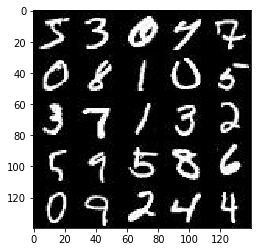

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

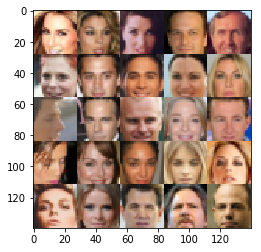

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')    
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
disc_depth_layer1 = 64
disc_depth_layer2 = 128
disc_depth_layer3 = 256
alpha = 0.02

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, disc_depth_layer1, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, disc_depth_layer2, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, disc_depth_layer3, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 (???)

        shape = relu3.get_shape().as_list()
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, shape[1]*shape[2]*disc_depth_layer3))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    
#     return None, None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
gen_depth_layer1 = 256
gen_depth_layer2 = 128
gen_depth_layer3 = 128

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*gen_depth_layer1)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, gen_depth_layer1))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, gen_depth_layer2, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x128 now
        
#         x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
#         x3 = tf.layers.batch_normalization(x3, training=training)
#         x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print(mnist_dataset.get_batches, mnist_dataset.shape, mnist_dataset.image_mode)

<bound method Dataset.get_batches of <helper.Dataset object at 0x000001A6D8011E10>> (60000, 28, 28, 1) L


In [12]:
def train(epoch_count, batch_size, z_dim, lr, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    print_every = 50
    show_every = 100
    show_n_img = 9
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learning_rate: lr})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learning_rate: lr})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, learning_rate: lr})
                    train_loss_g = g_loss.eval({input_z: batch_z, learning_rate: lr})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, show_n_img, input_z, data_shape[3], data_image_mode)
#                     gen_samples = sess.run(
#                                    generator(net.input_z, 3, reuse=True, training=False),
#                                    feed_dict={net.input_z: sample_z})
# #                     samples.append(gen_samples)
#                     _ = view_samples(-1, samples, 6, 12, figsize=figsize)
#                     plt.show()

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/4... Discriminator Loss: 0.4069... Generator Loss: 1.8929
Epoch 1/4... Discriminator Loss: 0.3975... Generator Loss: 3.3023


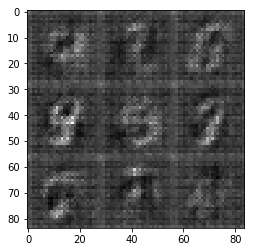

Epoch 1/4... Discriminator Loss: 0.5119... Generator Loss: 4.5429
Epoch 1/4... Discriminator Loss: 0.0673... Generator Loss: 3.7357


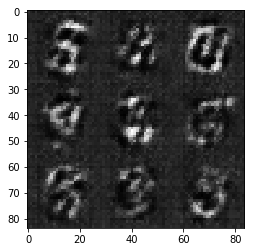

Epoch 1/4... Discriminator Loss: 0.3835... Generator Loss: 1.8853
Epoch 1/4... Discriminator Loss: 0.0871... Generator Loss: 3.5538


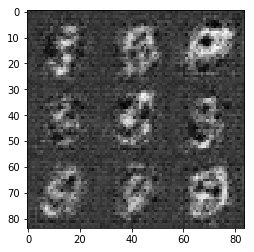

Epoch 1/4... Discriminator Loss: 0.0732... Generator Loss: 4.0709
Epoch 1/4... Discriminator Loss: 0.0793... Generator Loss: 3.3218


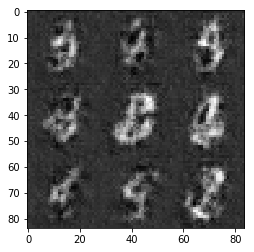

Epoch 1/4... Discriminator Loss: 0.2173... Generator Loss: 2.1209
Epoch 2/4... Discriminator Loss: 0.1080... Generator Loss: 3.0951


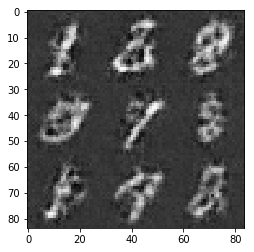

Epoch 2/4... Discriminator Loss: 0.0662... Generator Loss: 3.5987
Epoch 2/4... Discriminator Loss: 0.0828... Generator Loss: 3.4728


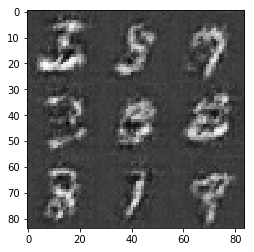

Epoch 2/4... Discriminator Loss: 0.0639... Generator Loss: 3.5245
Epoch 2/4... Discriminator Loss: 0.1589... Generator Loss: 2.4127


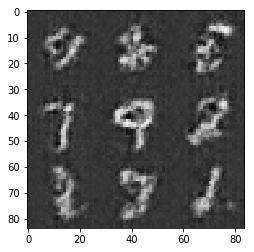

Epoch 2/4... Discriminator Loss: 0.0323... Generator Loss: 4.3587
Epoch 2/4... Discriminator Loss: 0.0601... Generator Loss: 3.9097


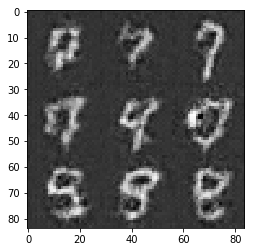

Epoch 2/4... Discriminator Loss: 0.1929... Generator Loss: 2.3561
Epoch 2/4... Discriminator Loss: 0.1056... Generator Loss: 2.8383


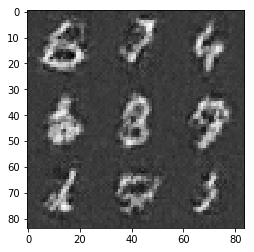

Epoch 3/4... Discriminator Loss: 0.1240... Generator Loss: 2.6075
Epoch 3/4... Discriminator Loss: 0.0930... Generator Loss: 3.0644


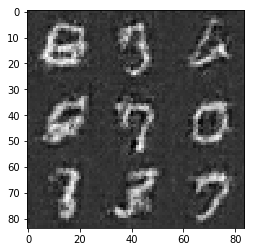

Epoch 3/4... Discriminator Loss: 0.5962... Generator Loss: 1.6065
Epoch 3/4... Discriminator Loss: 0.1754... Generator Loss: 2.6786


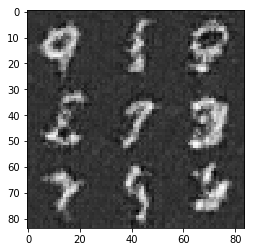

Epoch 3/4... Discriminator Loss: 0.1652... Generator Loss: 2.6597
Epoch 3/4... Discriminator Loss: 0.0813... Generator Loss: 3.1560


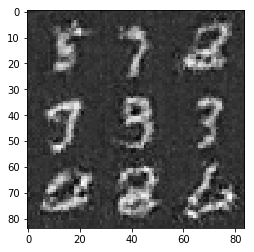

Epoch 3/4... Discriminator Loss: 0.0914... Generator Loss: 3.1773
Epoch 3/4... Discriminator Loss: 0.1206... Generator Loss: 2.6745


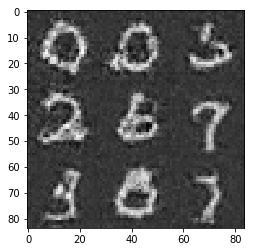

Epoch 3/4... Discriminator Loss: 0.1097... Generator Loss: 2.7537
Epoch 3/4... Discriminator Loss: 0.5962... Generator Loss: 1.7680


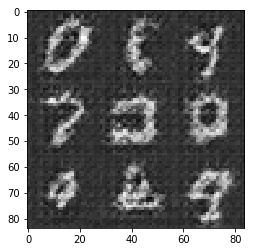

Epoch 4/4... Discriminator Loss: 0.2802... Generator Loss: 1.8035
Epoch 4/4... Discriminator Loss: 0.2219... Generator Loss: 2.0889


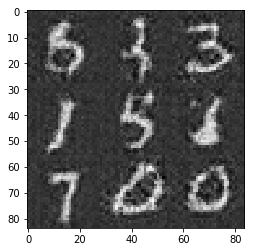

Epoch 4/4... Discriminator Loss: 0.1882... Generator Loss: 2.3167
Epoch 4/4... Discriminator Loss: 0.1058... Generator Loss: 2.6705


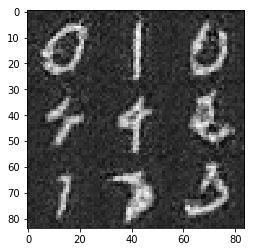

Epoch 4/4... Discriminator Loss: 0.1758... Generator Loss: 2.3244
Epoch 4/4... Discriminator Loss: 0.0793... Generator Loss: 3.2767


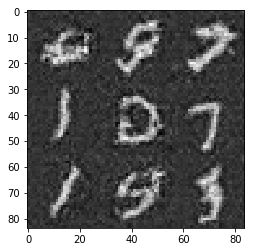

Epoch 4/4... Discriminator Loss: 0.0621... Generator Loss: 3.4814
Epoch 4/4... Discriminator Loss: 0.0661... Generator Loss: 3.4217


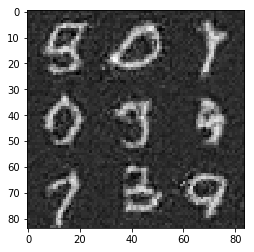

Epoch 4/4... Discriminator Loss: 0.7417... Generator Loss: 0.8485


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 4

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 0.4267... Generator Loss: 4.8417
Epoch 1/3... Discriminator Loss: 0.2723... Generator Loss: 2.5564


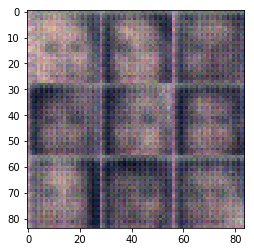

Epoch 1/3... Discriminator Loss: 0.1821... Generator Loss: 2.7068
Epoch 1/3... Discriminator Loss: 0.2748... Generator Loss: 1.9618


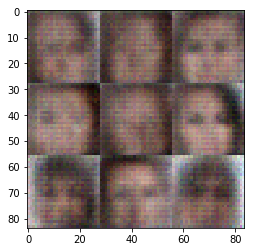

Epoch 1/3... Discriminator Loss: 0.2020... Generator Loss: 2.2034
Epoch 1/3... Discriminator Loss: 0.2005... Generator Loss: 3.4789


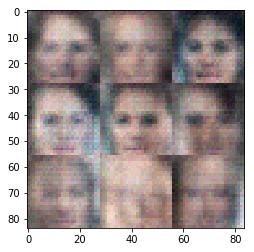

Epoch 1/3... Discriminator Loss: 0.1420... Generator Loss: 2.6856
Epoch 1/3... Discriminator Loss: 0.0910... Generator Loss: 3.8468


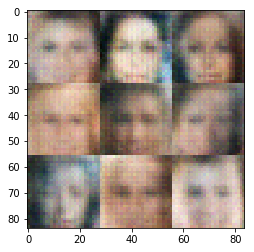

Epoch 1/3... Discriminator Loss: 0.9332... Generator Loss: 0.7038
Epoch 1/3... Discriminator Loss: 0.1314... Generator Loss: 5.2132


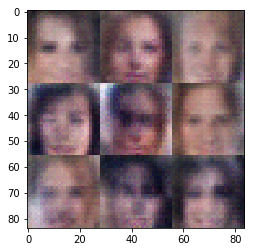

Epoch 1/3... Discriminator Loss: 0.1081... Generator Loss: 6.4524
Epoch 1/3... Discriminator Loss: 0.4500... Generator Loss: 8.7630


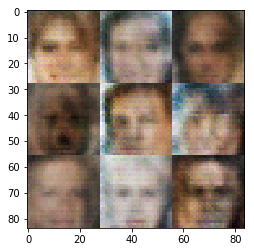

Epoch 1/3... Discriminator Loss: 0.1851... Generator Loss: 2.5473
Epoch 1/3... Discriminator Loss: 0.1777... Generator Loss: 2.1398


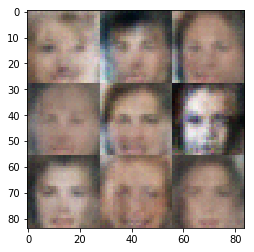

Epoch 1/3... Discriminator Loss: 0.1730... Generator Loss: 2.6782
Epoch 1/3... Discriminator Loss: 2.4454... Generator Loss: 0.1265


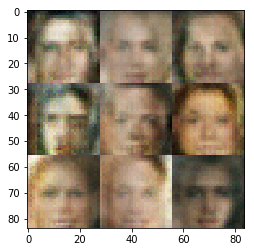

Epoch 1/3... Discriminator Loss: 0.2038... Generator Loss: 12.2896
Epoch 1/3... Discriminator Loss: 0.0070... Generator Loss: 12.5160


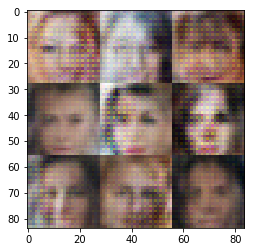

Epoch 1/3... Discriminator Loss: 0.3284... Generator Loss: 2.8678
Epoch 1/3... Discriminator Loss: 0.1417... Generator Loss: 4.8049


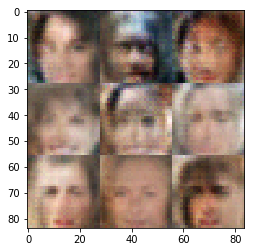

Epoch 1/3... Discriminator Loss: 0.3337... Generator Loss: 9.5670
Epoch 1/3... Discriminator Loss: 3.0126... Generator Loss: 0.0840


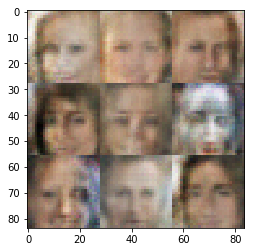

Epoch 1/3... Discriminator Loss: 0.0069... Generator Loss: 7.2916
Epoch 1/3... Discriminator Loss: 0.2915... Generator Loss: 2.3148


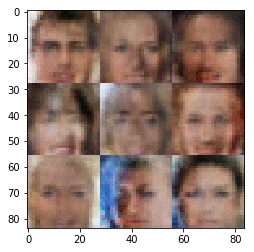

Epoch 1/3... Discriminator Loss: 0.1953... Generator Loss: 5.4275
Epoch 1/3... Discriminator Loss: 0.1452... Generator Loss: 12.6877


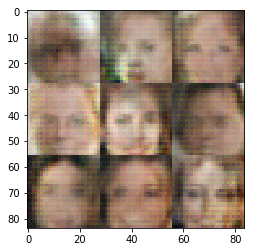

Epoch 1/3... Discriminator Loss: 0.4567... Generator Loss: 2.2705
Epoch 1/3... Discriminator Loss: 0.0381... Generator Loss: 10.7669


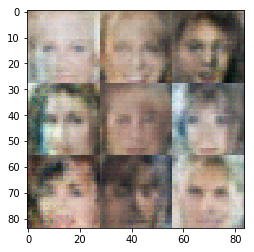

Epoch 1/3... Discriminator Loss: 0.9928... Generator Loss: 0.5487
Epoch 1/3... Discriminator Loss: 0.0271... Generator Loss: 6.5610


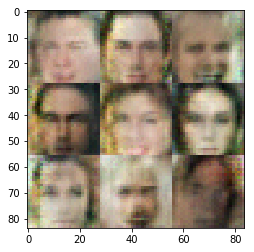

Epoch 1/3... Discriminator Loss: 0.0015... Generator Loss: 12.2475
Epoch 2/3... Discriminator Loss: 0.0527... Generator Loss: 3.4015


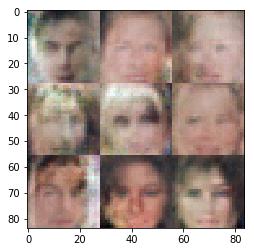

Epoch 2/3... Discriminator Loss: 0.0023... Generator Loss: 12.4707
Epoch 2/3... Discriminator Loss: 0.0271... Generator Loss: 12.6509


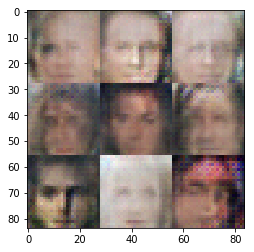

Epoch 2/3... Discriminator Loss: 0.1173... Generator Loss: 7.4776
Epoch 2/3... Discriminator Loss: 0.1170... Generator Loss: 7.6003


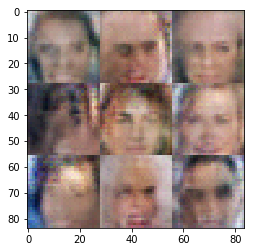

Epoch 2/3... Discriminator Loss: 0.7266... Generator Loss: 2.8068
Epoch 2/3... Discriminator Loss: 0.0223... Generator Loss: 11.4160


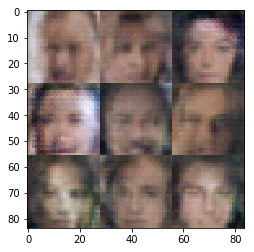

Epoch 2/3... Discriminator Loss: 0.2392... Generator Loss: 1.7459
Epoch 2/3... Discriminator Loss: 0.0308... Generator Loss: 10.7355


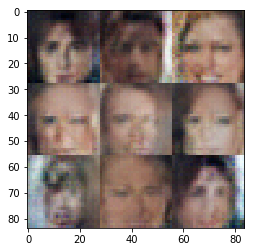

Epoch 2/3... Discriminator Loss: 0.0045... Generator Loss: 10.1666
Epoch 2/3... Discriminator Loss: 0.0126... Generator Loss: 12.5122


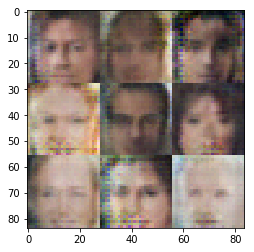

Epoch 2/3... Discriminator Loss: 0.0054... Generator Loss: 14.8056
Epoch 2/3... Discriminator Loss: 0.0009... Generator Loss: 15.4955


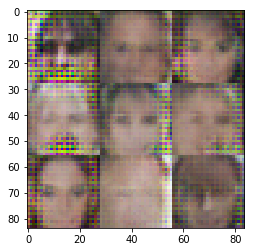

Epoch 2/3... Discriminator Loss: 0.0019... Generator Loss: 12.7413
Epoch 2/3... Discriminator Loss: 0.0006... Generator Loss: 10.3174


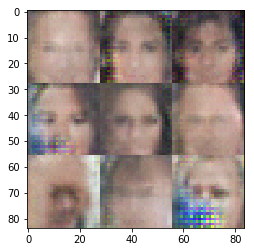

Epoch 2/3... Discriminator Loss: 0.0041... Generator Loss: 11.5681
Epoch 2/3... Discriminator Loss: 1.4256... Generator Loss: 0.7414


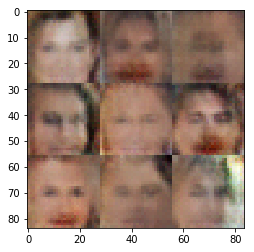

Epoch 2/3... Discriminator Loss: 0.0253... Generator Loss: 10.1293
Epoch 2/3... Discriminator Loss: 0.0040... Generator Loss: 8.9357


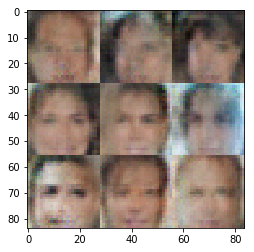

Epoch 2/3... Discriminator Loss: 0.0120... Generator Loss: 7.1182
Epoch 2/3... Discriminator Loss: 0.8526... Generator Loss: 0.9258


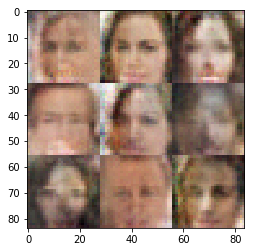

Epoch 2/3... Discriminator Loss: 0.0305... Generator Loss: 5.2146
Epoch 2/3... Discriminator Loss: 0.0483... Generator Loss: 5.3819


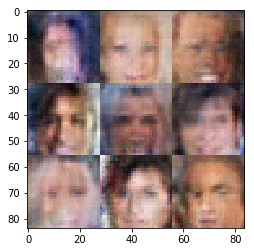

Epoch 2/3... Discriminator Loss: 0.0072... Generator Loss: 8.9010
Epoch 2/3... Discriminator Loss: 2.4360... Generator Loss: 6.5949


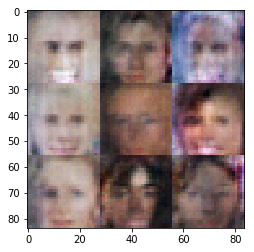

Epoch 2/3... Discriminator Loss: 0.9481... Generator Loss: 0.8133
Epoch 2/3... Discriminator Loss: 0.5997... Generator Loss: 1.8012


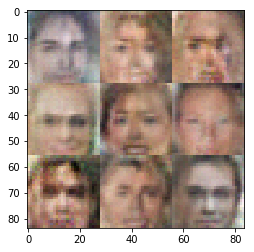

Epoch 2/3... Discriminator Loss: 0.8248... Generator Loss: 0.8138
Epoch 2/3... Discriminator Loss: 0.8795... Generator Loss: 0.8159


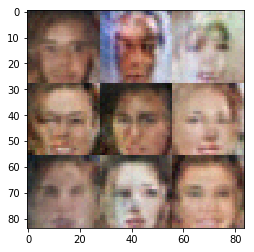

Epoch 2/3... Discriminator Loss: 0.2296... Generator Loss: 7.6214
Epoch 2/3... Discriminator Loss: 1.3168... Generator Loss: 3.6304


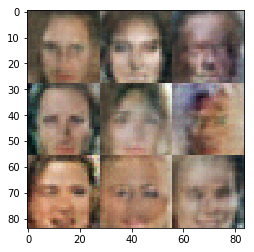

Epoch 2/3... Discriminator Loss: 0.4341... Generator Loss: 1.3587
Epoch 3/3... Discriminator Loss: 0.5126... Generator Loss: 1.3185


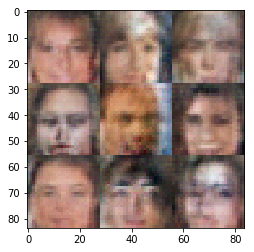

Epoch 3/3... Discriminator Loss: 0.2007... Generator Loss: 2.0752
Epoch 3/3... Discriminator Loss: 0.0837... Generator Loss: 3.0289


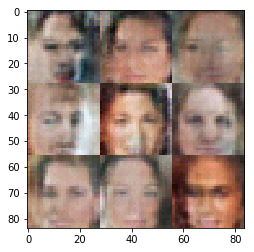

Epoch 3/3... Discriminator Loss: 0.0065... Generator Loss: 11.1573
Epoch 3/3... Discriminator Loss: 0.0279... Generator Loss: 4.8739


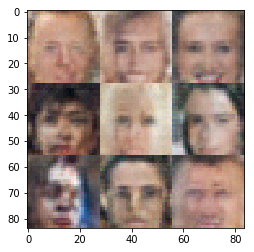

Epoch 3/3... Discriminator Loss: 0.2493... Generator Loss: 2.0130
Epoch 3/3... Discriminator Loss: 0.7569... Generator Loss: 14.4550


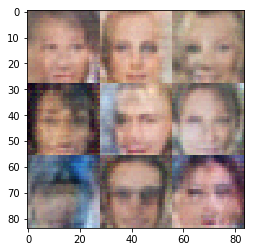

Epoch 3/3... Discriminator Loss: 0.0489... Generator Loss: 10.3225
Epoch 3/3... Discriminator Loss: 0.4314... Generator Loss: 5.0689


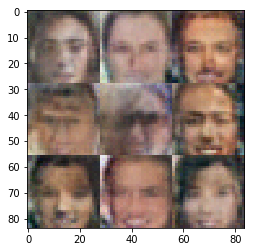

Epoch 3/3... Discriminator Loss: 0.0297... Generator Loss: 5.5601
Epoch 3/3... Discriminator Loss: 0.0070... Generator Loss: 11.3216


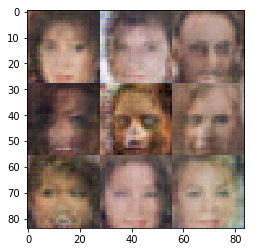

Epoch 3/3... Discriminator Loss: 0.0929... Generator Loss: 4.5713
Epoch 3/3... Discriminator Loss: 1.2508... Generator Loss: 0.4402


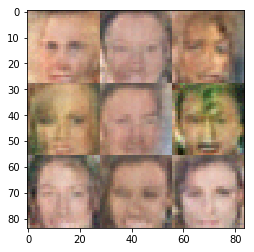

Epoch 3/3... Discriminator Loss: 0.9599... Generator Loss: 0.6422
Epoch 3/3... Discriminator Loss: 0.0766... Generator Loss: 7.3858


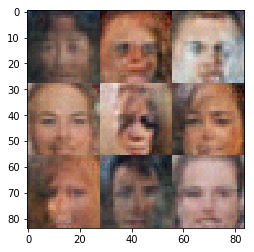

Epoch 3/3... Discriminator Loss: 0.0204... Generator Loss: 5.8382
Epoch 3/3... Discriminator Loss: 0.3829... Generator Loss: 1.4399


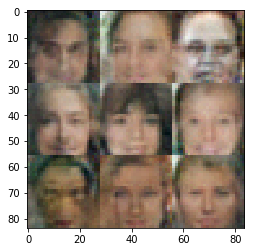

Epoch 3/3... Discriminator Loss: 0.0474... Generator Loss: 6.9012
Epoch 3/3... Discriminator Loss: 0.8222... Generator Loss: 0.7270


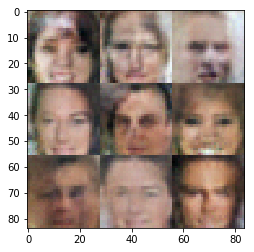

Epoch 3/3... Discriminator Loss: 0.0273... Generator Loss: 4.4597
Epoch 3/3... Discriminator Loss: 0.0209... Generator Loss: 6.3811


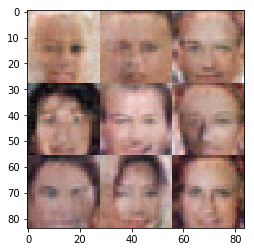

Epoch 3/3... Discriminator Loss: 0.5952... Generator Loss: 1.3416
Epoch 3/3... Discriminator Loss: 0.0568... Generator Loss: 4.0597


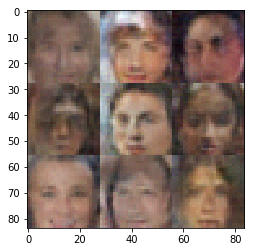

Epoch 3/3... Discriminator Loss: 0.0393... Generator Loss: 11.0903
Epoch 3/3... Discriminator Loss: 0.9220... Generator Loss: 0.7017


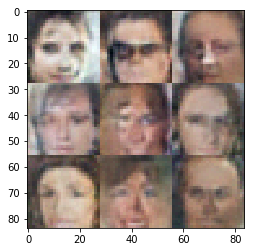

Epoch 3/3... Discriminator Loss: 1.0121... Generator Loss: 0.6248
Epoch 3/3... Discriminator Loss: 0.3837... Generator Loss: 1.7720


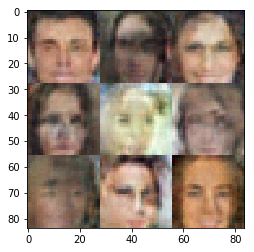

Epoch 3/3... Discriminator Loss: 0.2957... Generator Loss: 2.0067
Epoch 3/3... Discriminator Loss: 0.0277... Generator Loss: 6.2003


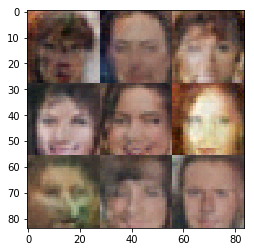

Epoch 3/3... Discriminator Loss: 0.4576... Generator Loss: 1.3263
Epoch 3/3... Discriminator Loss: 1.0219... Generator Loss: 0.6569


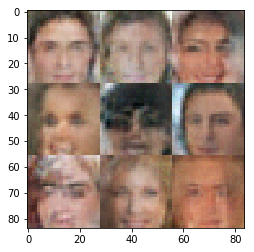

In [14]:
batch_size = 128
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.